## Preprocessing / Modeling Test
The purpose of this notebook is to test the structure of our data and try to forecast prices using an ARIMA model and an LSTM

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8049 entries, 0 to 8048
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nasdaq Traded     8049 non-null   object 
 1   Symbol            8049 non-null   object 
 2   Security Name     8049 non-null   object 
 3   Listing Exchange  8049 non-null   object 
 4   Market Category   8049 non-null   object 
 5   ETF               8049 non-null   object 
 6   Round Lot Size    8049 non-null   float64
 7   Test Issue        8049 non-null   object 
 8   Financial Status  3383 non-null   object 
 9   CQS Symbol        4666 non-null   object 
 10  NASDAQ Symbol     8049 non-null   object 
 11  NextShares        8049 non-null   object 
dtypes: float64(1), object(11)
memory usage: 754.7+ KB
number of stocks: 8049
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------

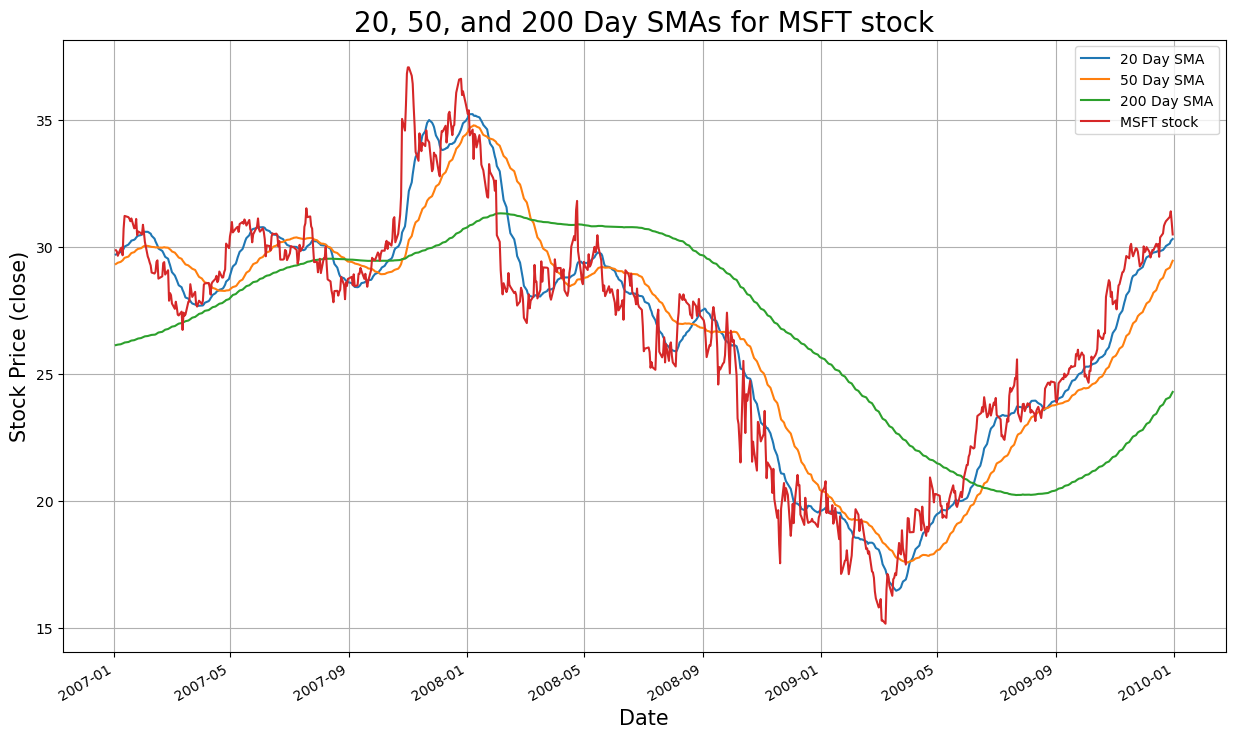

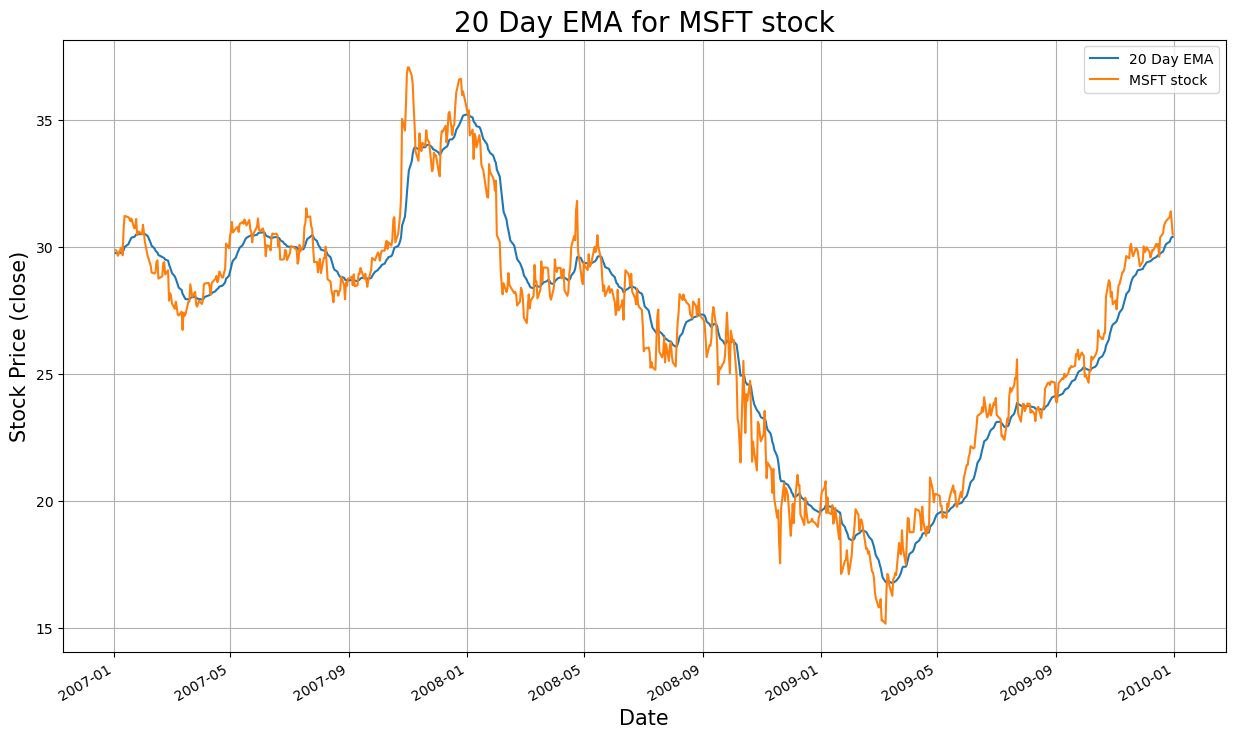

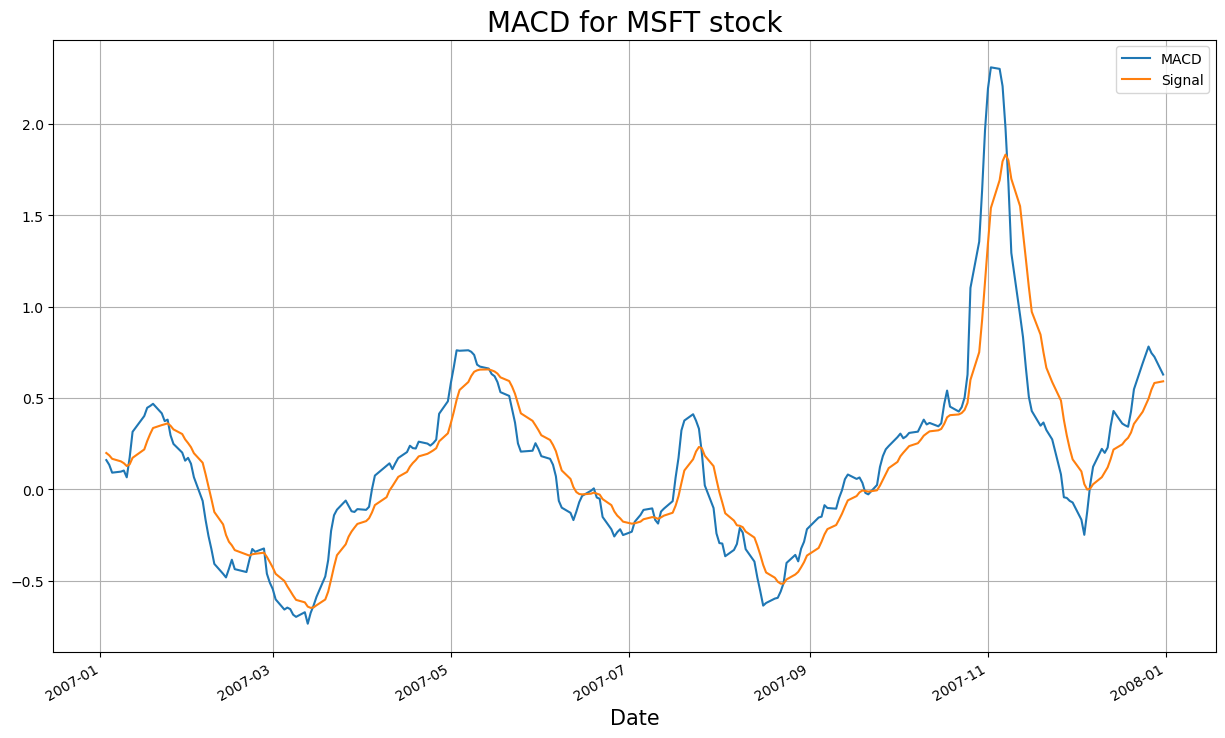

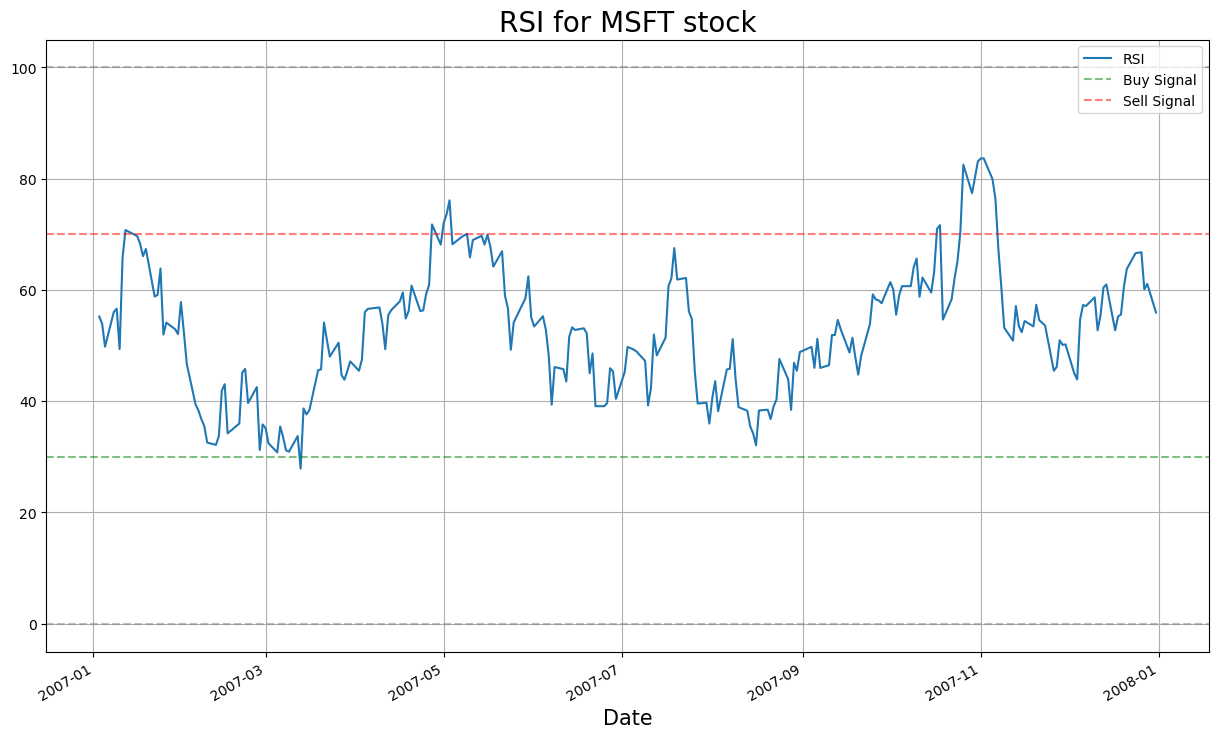

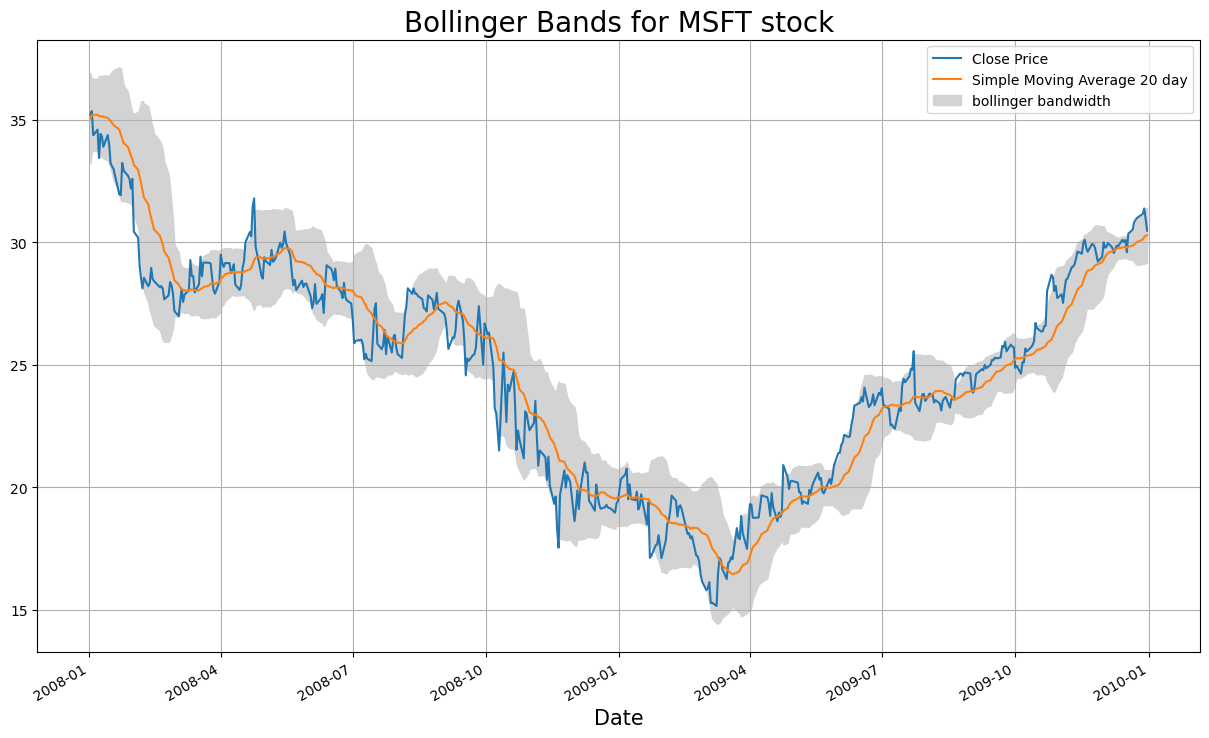

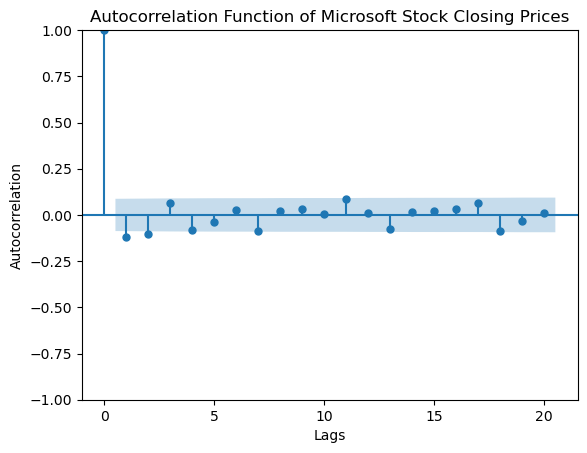

In [1]:
# importing libraries
import time
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#maybe we can bayesian optimize our ARIMA model?
from bayes_opt import BayesianOptimization

#importing from wrangling notebook
from wrangling_EDA import formatter, date_selector

# Keras imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator



In [2]:
# putting pandas_ta strategy here in case we want to try different metrics
MyStrategy = ta.Strategy(
    name="SMAs, EMAs, rsi, BBs, and MACD",
    ta=[
        {"kind": "sma", "length": 20}, # Simple Moving Average
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 200},
        {"kind": "ema", "length": 20},  # Exponential Moving Average
        {"kind": "rsi"}, # Relative Strength Index - indicator of momentum
        {"kind": "bbands", "length": 20, "col_names": ("BBL", "BBM", "BBU", "BBB", "BBP")},
        {"kind": "macd", "fast": 8, "slow": 21, "col_names": ("MACD", "MACD_H", "MACD_S")}
    ]
)

In [3]:
# reading in data

# formatter imports data for specified stock symbol, converts date to datetime object, sets date as index, adds pandas_ta metrics to 
stock = formatter('AAPL')

# isolates specific year range
stock = date_selector(stock,2015,2020)

stock.tail(3)

,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_200,EMA_20,RSI_14,BBL,BBM,BBU,BBB,BBP,MACD,MACD_H,MACD_S
Date,,,,,,,,,,,,,,,,,,,
2019-12-27,291.119995,293.970001,288.119995,289.799988,289.113831,36566500,274.455997,262.842800,218.11740,276.531866,78.405656,256.774293,274.455997,292.137700,12.884910,0.933895,7.746087,1.268146,6.477940
2019-12-30,289.459991,292.690002,285.220001,291.519989,290.829773,36028600,275.669496,263.967599,218.64440,277.959306,79.598963,256.838591,275.669496,294.500402,13.661944,0.920864,8.059382,1.265153,6.794229
2019-12-31,289.929993,293.679993,289.519989,293.649994,292.954712,25201400,277.143996,265.112399,219.17255,279.453657,80.999258,257.546231,277.143996,296.741760,14.142659,0.921119,8.397786,1.282846,7.114940


In [4]:
# checking for missing values
stock.isna().sum().any()

False

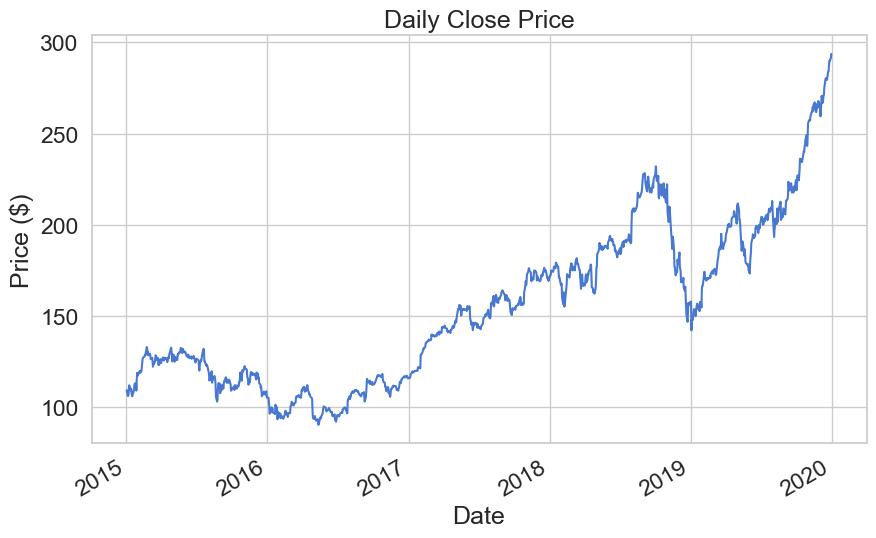

In [5]:
# Normalize data
df = stock[['Open','High','Low','Close','Volume']]

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# data plot
ax = df.plot(y='Close',figsize=(10,6),legend=False)
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.set_title('Daily Close Price')

plt.show()

In [6]:
scaler = MinMaxScaler()
close_price = df['Close'].values.reshape(-1, 1) # we need to convert shape from (1000, ) -> (1000, 1)
scaled_close = scaler.fit_transform(close_price)
scaled_close = scaled_close

In [7]:
# 60 day window. each sequence contains 60 days worth of data
seq_len = 120

def split_into_sequences(data, seq_len):
    # this is the max number of sequences given the data (we can't have sequences with fewer than 60 days)
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    #takes the data frame we want sequenced, the size of the sequences, and the fraction of our training data

    
    # obtaining numpy array containing our data split into sequences
    sequences = split_into_sequences(data, seq_len)

    # sequences.shape[0] is just the number of sequences in our array. it is the length of our data frame. This times train frac is how many samples for training
    n_train = int(sequences.shape[0] * train_frac)

    # notice here that X and Y are just fractions of the same variable. Because we're predicting a future version of itself. 
    # everything up to n_train
    X_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]

    # everything after n_train
    X_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]

    # returns same 4 variables as sklearn's train_test_split
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = get_train_test_sets(scaled_close, seq_len, 0.7)

In [9]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (797, 119, 1)
X_test shape: (342, 119, 1)
y_train shape: (797, 1)
y_test shape: (342, 1)


In [10]:
# Now the modeling itself
# Note: “Bidirectional” allows for training of the data sequence forwards and backwards.

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1 # I don't understand why this is different

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, X_train.shape[-1]))
)

model.add(Dropout(rate=dropout))
# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 119, 119)          57596     
                                                                 
 dropout (Dropout)           (None, 119, 119)          0         
                                                                 
 bidirectional (Bidirection  (None, 119, 476)          681632    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 119, 476)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 238)               567392    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2

In [11]:
batch_size = 35

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

start_time = time.time()

history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Epoch 1/25
19/19 [==============================] - 11s 471ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 2/25
19/19 [==============================] - 8s 432ms/step - loss: 0.0126 - val_loss: 0.0041
Epoch 3/25
19/19 [==============================] - 8s 433ms/step - loss: 0.0094 - val_loss: 0.0022
Epoch 4/25
19/19 [==============================] - 8s 433ms/step - loss: 0.0142 - val_loss: 0.0121
Epoch 5/25
19/19 [==============================] - 8s 437ms/step - loss: 0.0079 - val_loss: 0.0019
Epoch 6/25
19/19 [==============================] - 8s 443ms/step - loss: 0.0079 - val_loss: 0.0014
Epoch 7/25
19/19 [==============================] - 8s 435ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 8/25
19/19 [==============================] - 9s 469ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 9/25
19/19 [==============================] - 9s 453ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 10/25
19/19 [==============================] - 9s 455ms/step - loss: 0.0016 - val_loss: 0.001

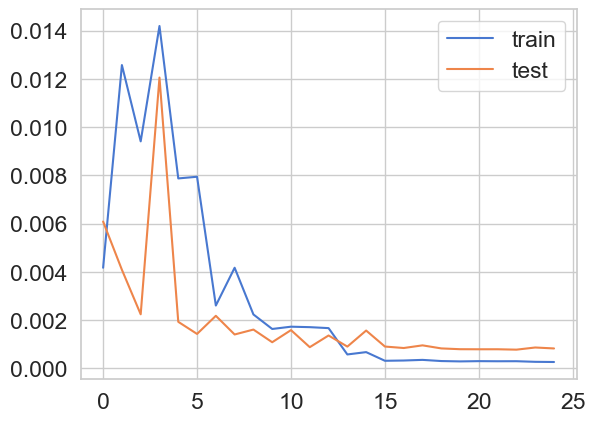

In [12]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

11/11 [==============================] - 2s 136ms/step


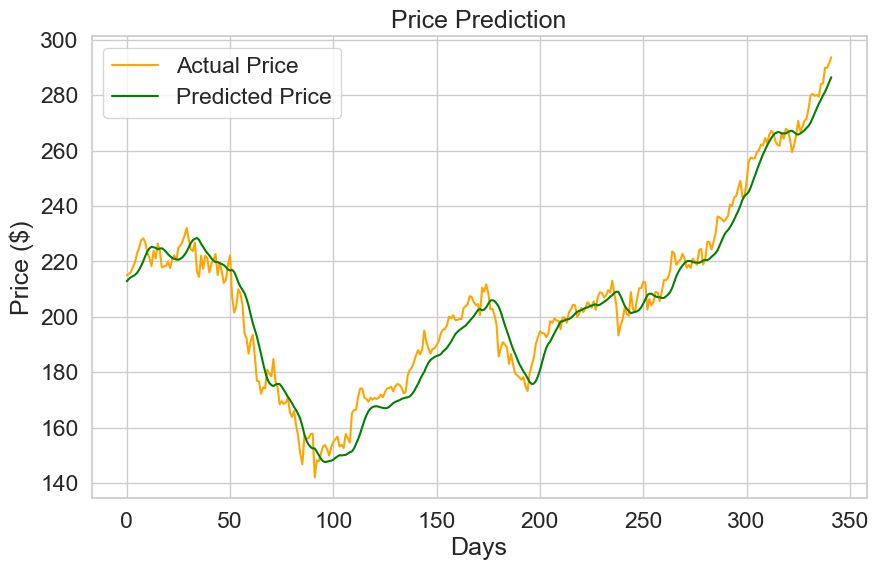

In [13]:
y_pred = model.predict(X_test)

# invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# plots of prediction against actual data
plt.figure(figsize=(10,6))
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')
 
plt.title('Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend(loc='best')

plt.show()

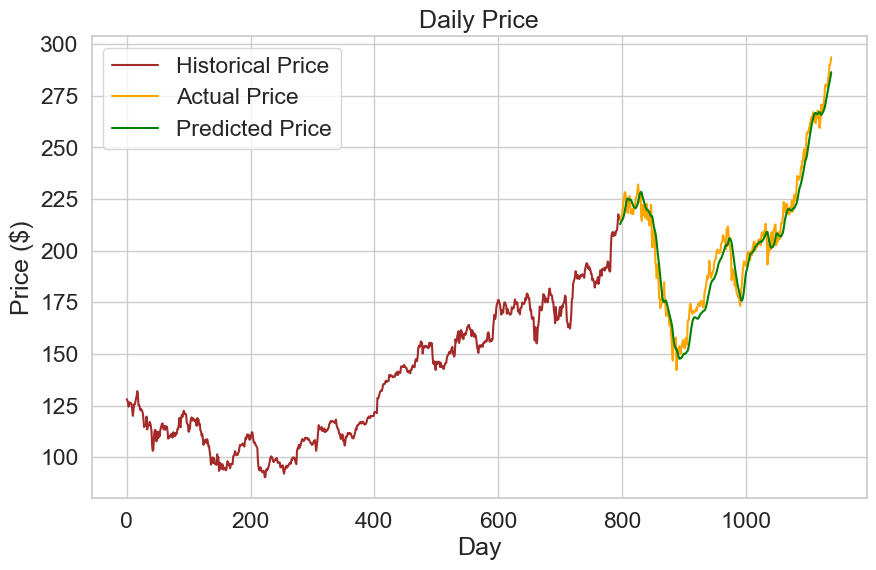

In [14]:
# plot for whole range of data

plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')
plt.title('Daily Price')
plt.xlabel('Day')
plt.ylabel('Price ($)')
plt.legend()
plt.show();

In [15]:
# This is pretty good. All models improved significantly when I Increased Sequence Length
# parameters that improved performace:
# train size of 0.7 instead of 0.9
# sequence length of 90 instead of 60 or 120
# date range of 5 years rather than 10.
# number of epochs = 25
# number of batches = 35

In [16]:
# Trying this model on another stock
def predict_other(stock_symbol):
    new_stock = formatter(stock_symbol)

    # isolates specific year range
    new_stock = date_selector(new_stock,2015,2020)

    new_close_price = new_stock['Close'].values.reshape(-1, 1)

    new_scaled_close = scaler.transform(new_close_price)

    X_train, X_test, y_train, y_test = get_train_test_sets(new_scaled_close, seq_len, 0.7)

    y_pred = model.predict(X_test)

    # invert the scaler to get the absolute price data
    y_test_orig = scaler.inverse_transform(y_test)
    y_pred_orig = scaler.inverse_transform(y_pred)

    # plots of prediction against actual data for just the prediction range
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(y_test_orig, label='Actual Price', color='orange')
    plt.plot(y_pred_orig, label='Predicted Price', color='green')
    plt.title(f'Price Prediction for {stock_symbol}')
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.legend(loc='best')

    # plots entire data range with predictions
    plt.subplot(1,2,2)
    plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Price')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')
    plt.title(f'Price Prediction for {stock_symbol}')
    plt.xlabel('Days')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.show()
    

11/11 [==============================] - 1s 114ms/step


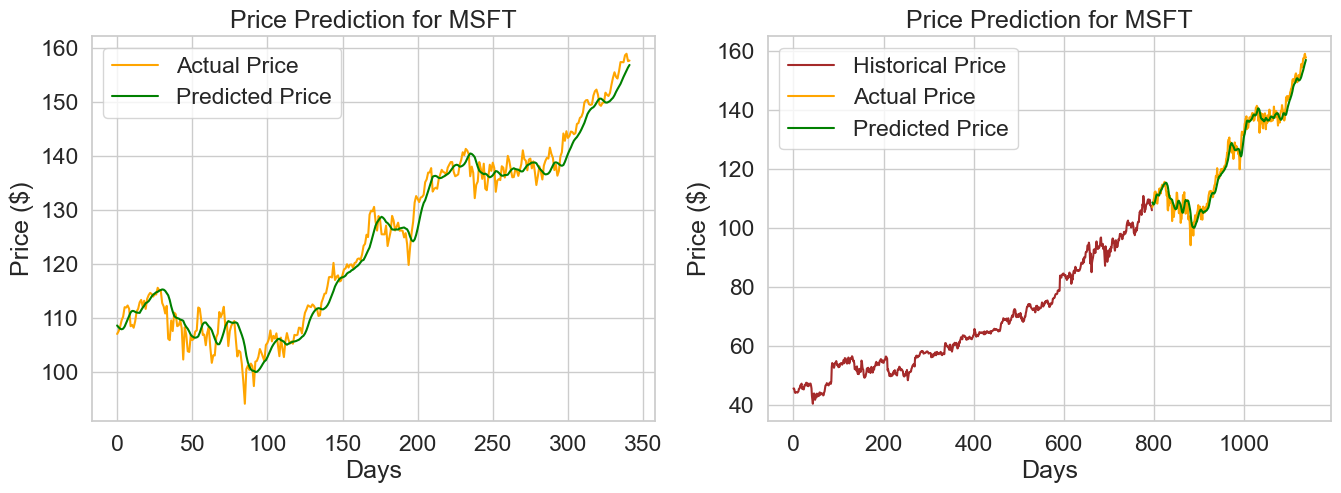

In [17]:
predict_other('MSFT')

11/11 [==============================] - 1s 123ms/step


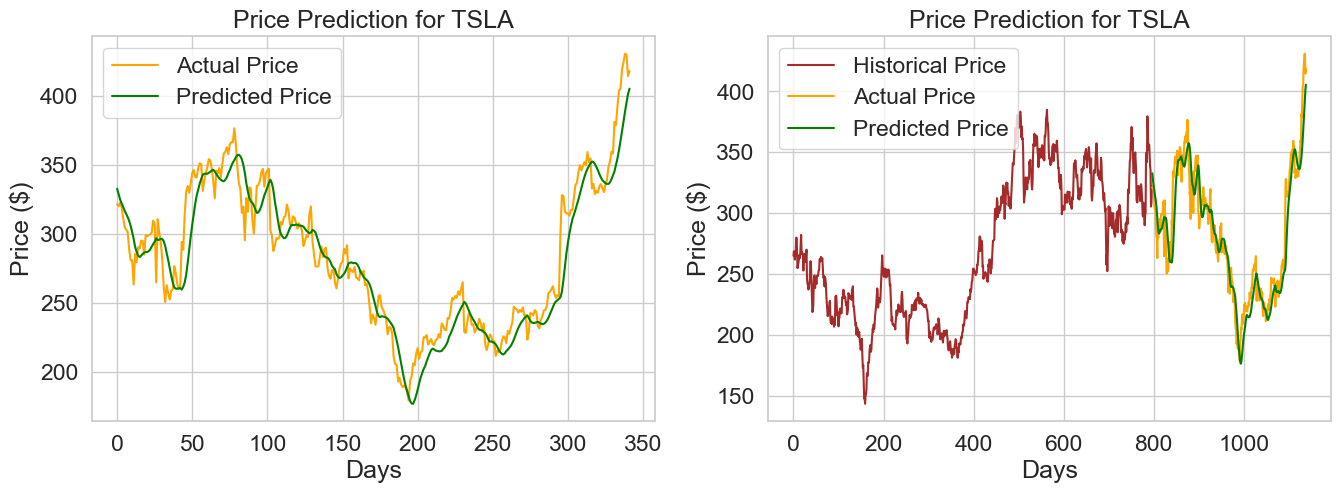

In [18]:
predict_other('TSLA')

11/11 [==============================] - 1s 119ms/step


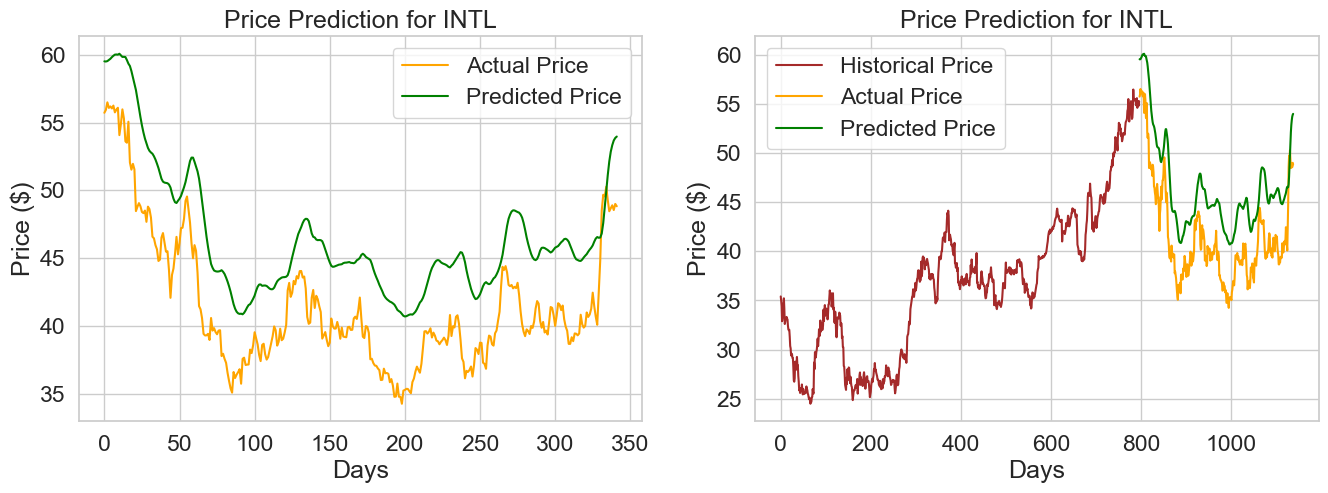

In [19]:
predict_other('INTL')

11/11 [==============================] - 1s 104ms/step


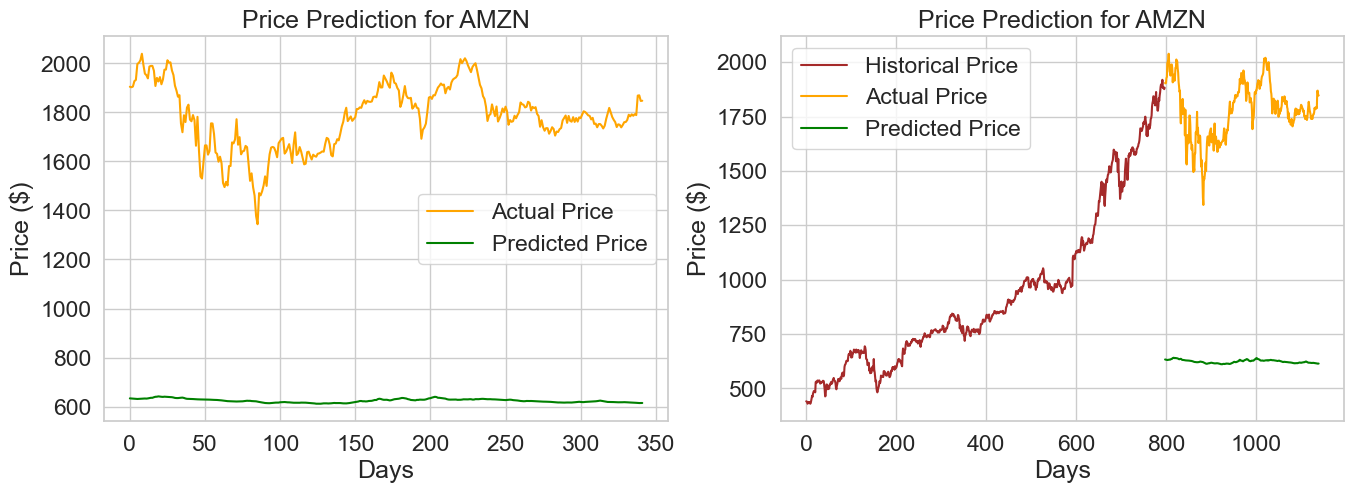

In [20]:
predict_other('AMZN')

11/11 [==============================] - 1s 105ms/step


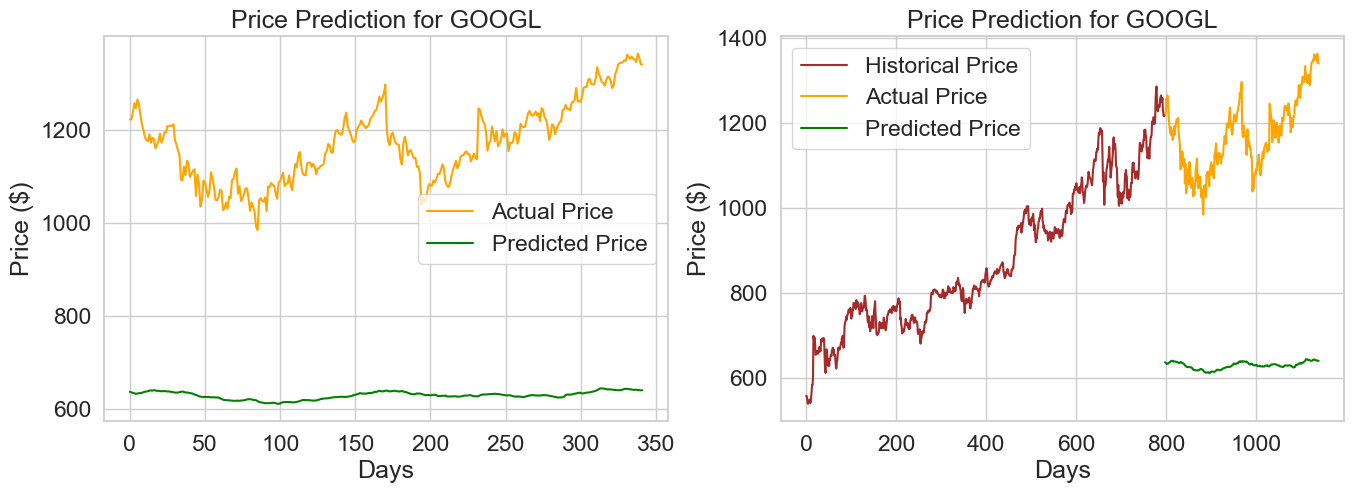

In [21]:
predict_other('GOOGL')

In [22]:
# This seems to predict very poorly for stocks that are much higheror lower in value than our training data.
# Google and Amazon had much higher prices and the model appears to be quite useless
# Intel on the other hand has much lower prices and it over predicts significantly